# An Analysis of UCI Mushroom Data


## Disclaimer

Unless you want to end up like the protagonist from _Into the Wild_, i.e. dead, I wouldn't recommend using the results from this data analysis to actually hunt mushrooms. This data set only represent 22 species and most likely can't be generalized. A quick google search reveals that there are at least 14,000 known species of mushrooms, 10,000 in North America alone. Remember, this only an exercise, not a definitive primer on how to identify edible mushrooms. 


## The Data

The mushroom dataset was donated to the University of California Irvine Machine Learning Repository in 1987. It consists of 8124 hypothetical samples which correspond to 23 species of gilled mushrooms in the Agaricus and Lepiota genera. The samples are constructed from The Audubon Society Field Guide to North American Mushrooms (1981). The samples are labeled as either 'e' or 'p' for edible or poisonous. Mushrooms which were of dubious or unknown edibility were incorporated as poisonous. The dataset includes 22 predictor variables which correspond to information regarding physical, visual and olfactory features of each specimen as well as habitat and growth pattern information.

## Data Preprocessing:

Initially the data is represented categorically however <code>sklearn</code> is incompatible with categorical data, therefore the data is first converted into dummy variables. We do this using the <code>pandas.get_dummies</code> function. <code>get_dummies</code> provides each category of data with its own column and replaces strings with 0s and 1s. <code>get_dummies</code> expands the number of independent variable columns from 22 to 117.

In [1]:
#import modules
import pandas as pd
import numpy as np

#read csv to pandas dataframe
mushrooms = pd.read_csv("mushrooms.csv")

#create dummy variables
mushrooms = pd.get_dummies(mushrooms)

#subset data into dependent and independent variables x,y
LABELS = ['class_e', 'class_p']
FEATURES = [a  for a in mushrooms.columns if a not in LABELS ]
y = mushrooms[LABELS[0]]
x= mushrooms[FEATURES]

mushrooms.head()

,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


## Visual EDA


### Visualizing clusters with T-SNE

Visual EDA (exploratory data analysis) is the first step in our data science pipeline. However, our data has too many dimensions to visualize directly. Luckily, smart people have figured out methods for representing higher dimensional data in lower dimensional spaces which can be visualized. One such method is [t-sne](https://www.youtube.com/watch?v=NEaUSP4YerM) or t-Distributed Stochastic Neighbor Embedding, a state of the art visualization method which is especially adept at preserving clustering. The plot below was constructed using <code>sklearn.manifold.TSNE</code> by setting the <code>learning_rate</code> parameter to 100. The t-sne plot separates the sample into clusters with color representing distinct classes, i.e. poisonous or edible. Here we observe a good separation between yellow and purple clusters. Therefore, we expect a machine learning algorithm to distinguish between edible and poisonous mushrooms with good accuracy.


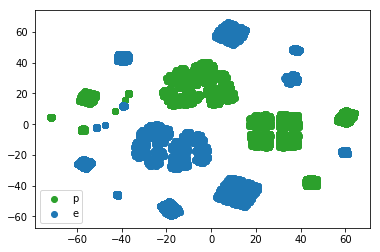

In [2]:
#import modules
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#create model
model = TSNE(learning_rate = 100)

#fit model
transformed = model.fit_transform(x.values)
xs = transformed[:,0]
ys = transformed[:,1]
df_trans = pd.DataFrame({'xs':xs, 'ys':ys})

#create plots
plt.scatter(df_trans.loc[y==0]['xs'], df_trans.loc[y ==0]['ys'], c= 'tab:green')
plt.scatter(df_trans.loc[y ==1]['xs'], df_trans.loc[y ==1]['ys'], c= 'tab:blue')
plt.legend(loc ='lower left', labels = ['p', 'e'])

plt.show()

### Exploring important variables with Lasso

[Lasso regression](https://www.youtube.com/watch?v=NGf0voTMlcs) is a type of linear regression which is used to prevent overfitting of data by penalizing high linear coefficients. One interesting property of Lasso compared to other similar techniques is that it tends to drop coefficients of unimportant variables to exactly zero, which gives it utility as a means to identify the most important variables in high dimensional problems. The plots below were constructed using <code>sklearn.linear_model.Lasso</code> with respective alphas of .1 and .001. Alpha or lambda is a parameter which sets the degree of the aforementioned penalty. The higher the alpha, the less sensitive Lasso will be to the data, the more variables coefficients will tend towards zero. With an alpha of .1, the plot reveals a single distinct spike in a field of zeroes corresponding to the property odor_n or odor of 'none'. At an alpha of .001, other variables emerge including odor_l (odor = 'anise') and odor_a (odor = 'almond'), which count towards edibility, as well as spore-print-color_r (color = 'green') and stalk-color-below-ring_y (color = yellow), which count against edibility. However, because these other variables did not appear at the higher alpha they are also less important overall. Odor_n is clearly the most important variable in our dataset. For instance, if we ignored every other variable and sorted the data into edible and poison categories based on whether the mushrooms exhibited an odor alone, we would be right 88.7% of the time with a false positive rate of 3.4%, which is pretty remarkable. Of course, a false positive rate of 3.4% is unacceptable in the scenario so we still need to consider other factors if we don't want to be poisoned eventually. 


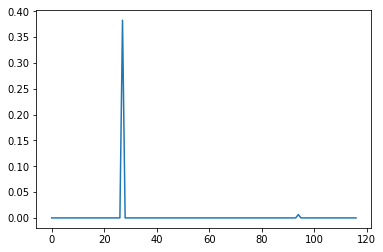

In [3]:
#import modules
from sklearn.linear_model import Lasso

#create model, set alpha
lasso = Lasso(alpha = 0.1)

#fit model, access coef_ attribute: lasso_coef
lasso_coef = lasso.fit(x,y).coef_

#create plot
_=plt.plot(range(len(x.columns)), lasso_coef)
plt.show()

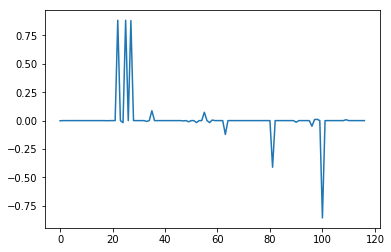

In [4]:
#import modules
from sklearn.linear_model import Lasso

#create model, set alpha
lasso = Lasso(alpha = 0.001)

#fit model, access coef_ attribute: lasso_coef
lasso_coef = lasso.fit(x,y).coef_

#create plot
_=plt.plot(range(len(x.columns)), lasso_coef)
plt.show()

## Supervised Learning: KNN and Decision Trees


### Training a KNN model

[K-nearest neighbors](https://www.youtube.com/watch?v=HVXime0nQeI&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=24&t=0s) (knn) is an algorithm used in classification problems, which predicts test data based on a tally of its k-nearest neighbors in the training data. Here we use sklearn's <code>GridSearchCV</code> to tune a K-nearest neighbors model. First we split the data into test data (30%) and training data (70%)  and define a parameter grid for possible values of k, in this case 1-9. Gridsearch by default uses three fold [cross-validation](https://www.youtube.com/watch?v=fSytzGwwBVw&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=3&t=0s) on each of the values in the parameter grid and saves the model with the best parameters, in this case k=1. Finally we test the model on the training data.  As you can see from the output below our knn model performs perfectly on the test data. Here precision and recall are outputted instead of accuracy. A precision of 1 means that the model did not output any false positives, i.e. predicted edible when in fact poisonous. A recall of 1 means that the model also did not output any false negatives, i.e. predicted poisonous when in fact edible.

In [5]:
#import modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

#create parameter grid for values of k
parameters = {'knn__n_neighbors': np.arange(1,10)}

#instatiate pipeline with KNNClassifier: pl
pl = Pipeline([('knn', KNeighborsClassifier())])

#split data into test and training data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#instatiate GridsearchCV:cv
cv = GridSearchCV(pl, param_grid= parameters, cv = 3)

#fit model to training data
cv.fit(X_train, y_train)

#predict test data: y_pred
y_pred = cv.predict(X_test)


In [6]:
#print performance metrics
print (cv.best_params_)
print(classification_report(y_test, y_pred))

{'knn__n_neighbors': 1}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1181
           1       1.00      1.00      1.00      1257

   micro avg       1.00      1.00      1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



### Decision Tree

A [Decision Tree](https://www.youtube.com/watch?v=7VeUPuFGJHk) is a model which uses a series of specially selected questions to iteratively optimize the classifications of data. When data contains mixed classes, it is called 'impure'. The learning algorithm selects questions at each node which minimize a measure of impurity,  compared to previous nodes. The decision tree was constructed using sklearn's <code>DecisionTreeClassifier</code> and the graphic representation was made using <code>graphviz</code>.  The first node evaluates whether the sample has the property odor = n, if it does it is classifies the sample as edible if not it classifies the sample as poisonous. The reason the algorithm picked odor_n for the root node is because evaluating this property maximized the separation between poisonous and edible mushrooms as measured by by the Gini impurity metric. For instance, at the root node the training data had a [2951,2735] division between edible and poisonous mushrooms respectively, after the first split the first edible internal node now contains 2141 edible samples and only 81 poisonous samples with a Gini of .063 down from .499. Similarly the first poisonous internal node now contains 537 edible samples and 2654 poisonous samples with a Gini of 0.28. According to representation below, the model is able to perfectly split the training data into edible and poisonous categories as noted by ginis of 0 at the end leaf nodes. Further, the model generalized perfectly to unseen test data split prior to training. 

Armed with this trusty decision tree, we can hunt mushrooms without fear of ingesting poison (not in real life!). When in doubt we need only consult the decision tree to determine if a mushroom is edible or poisonous. For instance, we will know that a mushroom with an odor of 'none', a broad gill size and which doesn't have a green spore print, a scaly stalk surface below the ring, a grooved cap surface, or a conical cap shape, will always be edible. This rule is a good one to know since it encompasses 76% of the edible mushrooms in our dataset. Aggregated from 8124 samples in 118 dimension and condensed into one simple chart that can easily be stuffed in a pocket or memorized. Pretty cool!

In [7]:
#import modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import export_graphviz


#instantiate DecisionTreeClassifier:tree
tree = DecisionTreeClassifier()

#split data into test and training data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#fit data
tree.fit(X_train, y_train)

#predict test data:y_pred
y_pred=tree.predict(X_test)

#print performance metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



[[1181    0]
 [   0 1257]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1181
           1       1.00      1.00      1.00      1257

   micro avg       1.00      1.00      1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



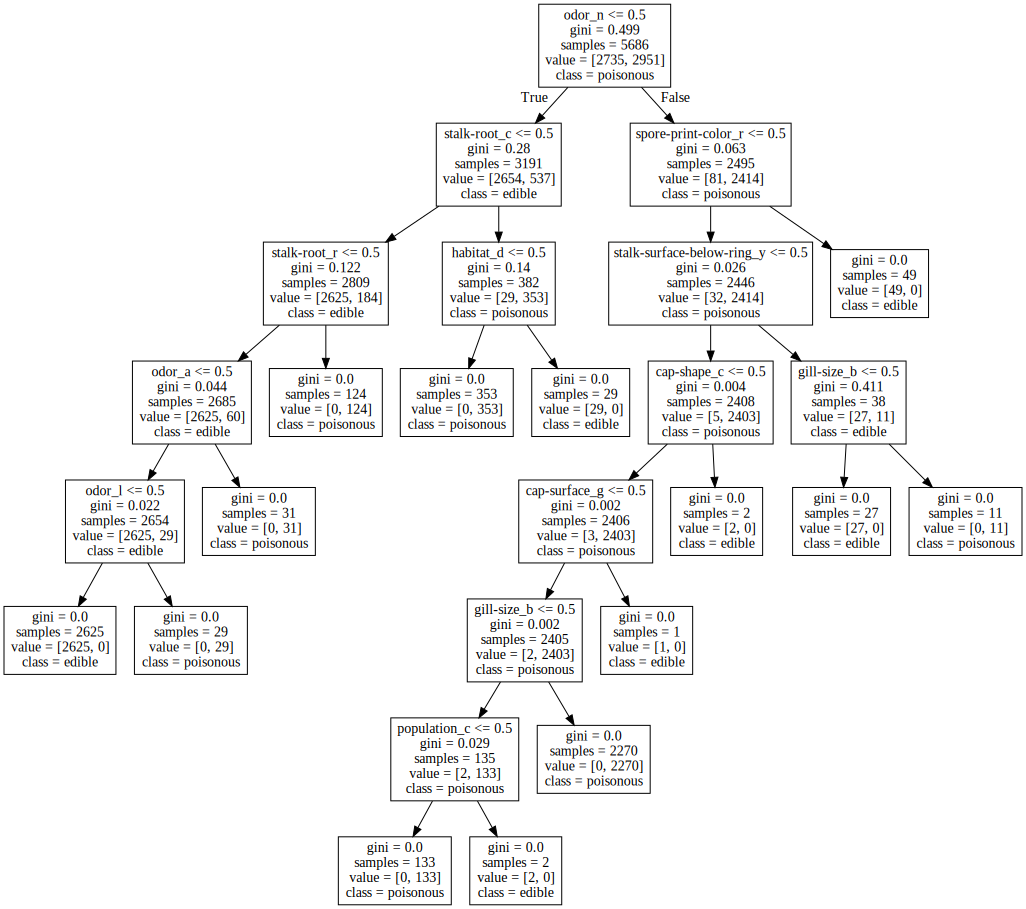

In [8]:
import graphviz

#export a graphic representation of tree to file
dot_data =export_graphviz(tree, out_file = None, feature_names =x.columns, class_names = ['edible', 'poisonous'])
graph = graphviz.Source(dot_data)
graph


## Unsupervised Learning: How many species of mushrooms are in our data set?


### Exploring the question

How many species of mushrooms are in our dataset? We already know the answer to this question. The description of the dataset states that the hypothetical sample corresponds to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. However, description aside, could we arrive at this conclusion independently based solely on the structure of the data? Further, can we restore species labels to the data? One strategy is to count the different clusters in our t-sne plot, assuming that different species are represented by different clusters. If we do this we get 23 clusters. This method however is subjective. It is unclear whether some smaller closely spaced clusters should be counted together, or whether some larger clusters should be broken up. Subjectivity, aside, counting the clusters on the t-sne is an important first step. By the time we are done with t-sne we have a good ballpark estimate as to what the answer will be. The rest is just confirming in what we already kind of know. One downside with the t-sne approach is that it doesn't restore species labels to the samples themselves. Therefore we proceed to cluster analysis. 


### Cluster Analysis: K-means and hierarchical clustering

With cluster analysis there are many approaches we could take. Here we try three using [k-means](https://www.youtube.com/watch?v=4b5d3muPQmA) and [hierarchical clustering](https://www.youtube.com/watch?v=7xHsRkOdVwo), picking the one that performs best according to a chosen performance metric. Assuming that species are homogenous with respect to edibility, we define the best clustering technique as the one that optimizes homogeneity while minimizing the total number of clusters. In other words, we assume that a given species will only contain members which are all 'edible' or all 'poisonous', but not both. A homogeneity score is calculated using sklearn's <code>homogeneity_completeness_v_measure</code>. The function evaluates homogeneity of cluster labels given a ground truth, in this case edibility labels. It returns a homogeneity of 1 if the cluster labels perfectly separate the edibility labels. The function also calculates two other metrics which are less relevant in this situation given that we expect multiple species to exhibit both edibility and toxicity. For each model type we loop through parameters which alter the number of clusters in the model. For each iteration of the loop we append the number of clusters to list xp, and the homogeneity score to list yp. Once the loop is complete xp and yp are plotted using <code>matplotlib.pyplot</code>.

The two clustering techniques used here are k-means and hierarchical clustering. K-means was implemented using <code>sklearn.cluster.KMeans</code>. K-means is a top down approach. The model receives the number of desired clusters and attempts to optimize the clusters by minimizing the sum of squared distances of samples to closest cluster centers, called inertia. Because the k-means iterative optimization process is highly dependent on randomly selected starting points for cluster centers, the algorithm typically is repeated several times to find the best clustering. By default in sklearn <code>n_init</code> will run the algorithm ten times with different centroid seeds and return the model with the lowest inertia.

Hierarchical clustering is a bottom up approach. The algorithm iteratively merges samples and clusters based on which samples are clusters are most similar. How ‘similar’ is defined is a matter of choice. Here we try two approaches: i) clustering based on an average pairwise distance between points in different clusters and ii) based on the centroid distance between two clusters. In this case we set the number of clusters indirectly by specifying a distance threshold which prevents clusters with similarity measures above the specified threshold from merging. Hierarchical clustering was implemented using <code>scipy.cluster.hierarchy.fcluster</code> and <code>scipy.cluster.hierarchy.linkage</code>. First we instantiate a linkage matrix with our data and define the desired linkage method. By default <code>linkage</code> defines distance as the euclidean distance. Then we pass the linkage matrix and our desired threshold criteria to <code>fcluster</code> which returns an array of cluster labels corresponding to our data. With <code>fcluster</code> instead of directly looping through the number of desired clusters as we did with k-means we instead loop through different distance threshold criteria, which indirectly vary the number of clusters. By iteratively decreasing the distance threshold we effectively increase the number of clusters. Again after each iteration we append the number of clusters to xp and the homogeneity score to yp and plot the result.

As can be seen from the plots, the different clustering methods provide similar ranges for the number of species. K-means performs the worst, since it never achieves 100% homogeneity instead leveling off at about 97%. That said, the results of k-means indicate that the number of species contained in our dataset is around 25 which is not too far off from the truth. Hierarchical clustering using  ‘average’ and ‘centroid’ criteria do slightly better. Using a linkage method of ‘average’ hits 100% of homogeneity at 24, while ‘centroid’ hits 100% homogeneity at 23. Based on our previously stated criteria of maximizing homogeneity while minimizing total clusters, the centroid method is the winner. Further, it predicts 23 clusters which is commensurate with the number of species we know to be true. So even if we didn’t know the answer to this particular question, based on cluster analysis we would still have a good reason to believe that the dataset contained 23 species based on a cluster analysis of the data. Even better, we now have best guess species labels for each of the samples in our dataset. Pretty cool. 



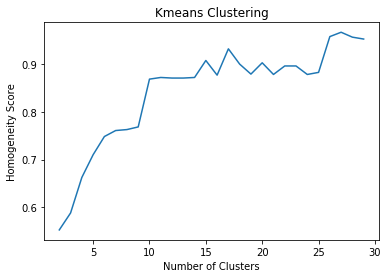

In [9]:
#import modules
from sklearn.cluster import KMeans
from sklearn import metrics

#instantaiate lists
xp=[]
yp=[]

# fit KMeans model for n_clusters 2:30
for i in range(2,30):
    model = KMeans(n_clusters = i, random_state = 42)
    model.fit(x.values)
    labels = model.predict(x)
    scores =metrics.homogeneity_completeness_v_measure(y, labels)
    xp.append(i)
    yp.append(scores[0])
plt.plot(xp,yp)
plt.title('Kmeans Clustering')
plt.xlabel(s = 'Number of Clusters')
plt.ylabel(s = 'Homogeneity Score')
plt.show()

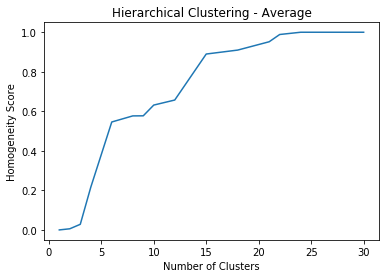

In [10]:
#import modules
from scipy.cluster.hierarchy import linkage,  fcluster

#instantiate linkage with 'average'
merging = linkage(x, method = 'average')

#create empty lists
xp=[]
yp=[]

#modify distance threshold of clustering and append cluster number and homogeneity scores to xp, yp
for i in range(30):
    labels = fcluster(merging,6-i*.1, criterion= 'distance')
    scores =metrics.homogeneity_completeness_v_measure(y, labels)
    xp.append(len(np.unique(labels)))
    yp.append(scores[0])

#plot number of cluster vs homogeneity score
plt.plot(xp,yp)

plt.title('Hierarchical Clustering - Average')
plt.xlabel(s = 'Number of Clusters')
plt.ylabel(s = 'Homogeneity Score')

plt.show()

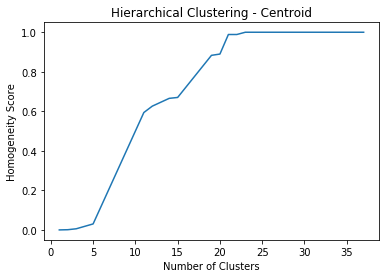

In [11]:
#instantiate linkage with 'centroid'
merging = linkage(x, method = 'centroid')

#create empty lists
xp=[]
yp=[]

#modify distance threshold of clustering and append cluster number and homogeneity scores to xp, yp
for i in range(40):
    labels = fcluster(merging,6-i*.1, criterion= 'distance')
    scores =metrics.homogeneity_completeness_v_measure(y, labels)
    xp.append(len(np.unique(labels)))
    yp.append(scores[0])

#plot number of cluster vs homogeneity score
plt.plot(xp,yp)

plt.title('Hierarchical Clustering - Centroid')
plt.xlabel(s = 'Number of Clusters')
plt.ylabel(s = 'Homogeneity Score')
plt.show()

###  T-sne revisited

We can use t-sne to visualize how well our chosen clustering performs on the data. As before, we plot the transformed data with the points color coded according to their edibility. Additionally we annotate the plot with the species labels commensurate with the cluster centers. The plot below confirms that the calculated cluster centers for each species label visually correspond with the apparent clusters on the t-sne plot. The t-sne plot also allows us to assess the edibility and the size of the different species. For instance, the largest edible species is 16 followed by 13 and 21, whereas the largest poisonous species are 9 and 5. In fact species 16, 13 and 21 comprise 71% of all the edible samples in the dataset while  9 and 5 comprise 77% of all poisonous mushrooms in the dataset. Therefore learning to identify these species would be a good return on investment for our hypothetical mushroom hunters.


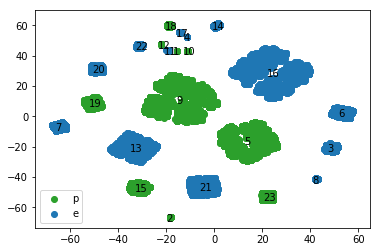

In [12]:
#create species labels using optimal clustering parameters
species = fcluster(merging,2.3, criterion= 'distance')

#transform mushroom data using-tsne
model = TSNE(learning_rate = 100)
transformed = model.fit_transform(x.values)
xs = transformed[:,0]
ys = transformed[:,1]
df_trans = pd.DataFrame({'xs':xs, 'ys':ys})

#determine centroid locations of t-sne clusters
cpx =[]
cpy=[]

for i in range(1,24):
    xi = df_trans.loc[(species ==i)]['xs'].mean()
    yi = df_trans.loc[(species ==i)]['ys'].mean()
    cpx.append(xi)
    cpy.append(yi)

#plot edible and poisonous samples with different colors
plt.scatter(df_trans.loc[y==0]['xs'], df_trans.loc[y ==0]['ys'], c= 'tab:green' )
plt.scatter(df_trans.loc[y ==1]['xs'], df_trans.loc[y ==1]['ys'], c= 'tab:blue')

#annotate clusters centroids for each species
for i in range(1,24):
    plt.annotate(s = str(i), xy = (cpx[i-1], cpy[i-1]), xytext = (-4,-4), textcoords = 'offset points')

#insert legend with labels 'p', 'e'
plt.legend(loc ='lower left', labels = ['p', 'e'])
plt.show()

## Conclusion and next steps

I think this is a good place to stop for now. We've learned a lot about our dataset. We started by using t-sne to visualize the dataset in a way that otherwise would have been impossible, we used lasso regression to determine that the most important predictor of edibility in our dataset is lack of smell, we trained knn and decision tree models which generalized to unseen test data and we used cluster analysis to restore species labels, which were not included in the original dataset. Now that we have species labels we can extend our inquiries further. We can determine the distinctive characteristics of each species and create data sheets and decision trees to assist in identification of species individually. We can create a taxonomy, based on similarity to determine which species are most related. We can investigate which characteristics are most likely to vary between species and which one are most likely the vary within species. Perhaps I will revisit some of these inquiries in the future.

Also if you enjoyed this analysis, check out my blog at [https://www.notnormalblog.com](https://www.notnormalblog.com). 